In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/myccds/all.csv


In [2]:
import pandas as pd
df = pd.read_csv('../input/all.csv')
df.head()

FileNotFoundError: [Errno 2] File b'../input/all.csv' does not exist: b'../input/all.csv'

In [3]:
import pandas as pd


In [4]:
df = pd.read_csv('../input/myccds/all.csv')


In [5]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,1
3,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
11,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",2
12,Debt collection,While checking my credit report I noticed thre...,0


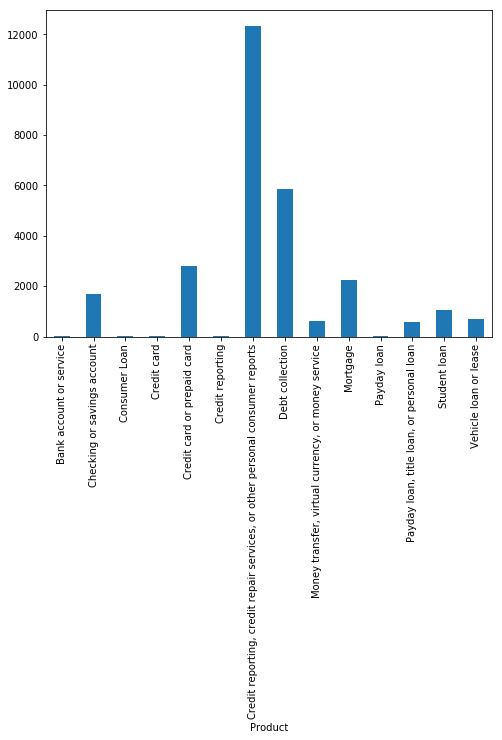

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(27881, 71827)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(27881, 71827)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. organized
. chip
  . Most correlated bigrams:
. chip card
. service claims
# 'Checking or savings account':
  . Most correlated unigrams:
. overdraft
. deposit
  . Most correlated bigrams:
. savings account
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. unorganized
. temp
  . Most correlated bigrams:
. application fraudulent
. loan opportunity
# 'Credit card':
  . Most correlated unigrams:
. darn
. macy
  . Most correlated bigrams:
. department receive
. imagine surprise
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. examine
. req
  . Most correlated bigrams:
. regarding information
. date regarding
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. report
. reporting
  . Most correlated bigrams:
.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [12]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [13]:
print(clf.predict(count_vect.transform(["i wont be able to your bedt, since i am not doing fine debt"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [14]:
print(clf.predict(count_vect.transform(["i wont be able to your bedt, since i am not doing collect debt"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [15]:
print(clf.predict(count_vect.transform(["i wont be able to your debt, since i am not doing collect debt"])))

['Debt collection']
